In [1]:
!git clone https://github.com/N-Nieto/Inner_Speech_Dataset.git

Cloning into 'Inner_Speech_Dataset'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 276 (delta 114), reused 86 (delta 75), pack-reused 138
Receiving objects: 100% (276/276), 115.27 KiB | 5.49 MiB/s, done.
Resolving deltas: 100% (171/171), done.


In [2]:
!pwd

/kaggle/working


In [3]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [4]:
!cd Inner_Speech_Dataset

In [5]:
!ls

Inner_Speech_Dataset  __notebook__.ipynb


In [6]:
#@title Imports 
import os
import mne 
import pickle
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt

# from google.colab import drive, files

from Inner_Speech_Dataset.Python_Processing.Data_extractions import  extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  select_time_window, transform_for_classificator, split_trial_in_time

np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 

In [7]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def create_preprocessor(X_train, X_test):

    def get_card_split(df, cols, n=11):
        """
        Splits categorical columns into 2 lists based on cardinality (i.e # of unique values)
        Parameters
        ----------
        df : Pandas DataFrame
            DataFrame from which the cardinality of the columns is calculated.
        cols : list-like
            Categorical columns to list
        n : int, optional (default=11)
            The value of 'n' will be used to split columns.
        Returns
        -------
        card_low : list-like
            Columns with cardinality < n
        card_high : list-like
            Columns with cardinality >= n
        """
        cond = df[cols].nunique() > n
        card_high = cols[cond]
        card_low = cols[~cond]
        return card_low, card_high

    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
    
    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    categorical_features = X_train.select_dtypes(include=["object"]).columns

    categorical_low, categorical_high = get_card_split(
        X_train, categorical_features
    )

    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

    categorical_transformer_low = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("encoding", OneHotEncoder(handle_unknown="ignore", sparse=False)),
        ]
    )

    categorical_transformer_high = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            # 'OrdianlEncoder' Raise a ValueError when encounters an unknown value. Check https://github.com/scikit-learn/scikit-learn/pull/13423
            ("encoding", OrdinalEncoder()),
        ]
    )

    preprocessor = ColumnTransformer(
                transformers=[
                    ("numeric", numeric_transformer, numeric_features),
                    ("categorical_low", categorical_transformer_low, categorical_low),
                    ("categorical_high", categorical_transformer_high, categorical_high),
                ]
            )
    
    return preprocessor


def train_brute_search_extraTree(X_train, y_train, X_test, y_test, num_iter = 1000):
    best_acc = 0
    best_model = None

    accs = []

    for i in tqdm(range(num_iter)):
        preprocessor = create_preprocessor(X_train, X_test)
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", ExtraTreeClassifier())])
        pipe.fit(X_train, y_train)

        train_preds = pipe.predict(X_train)
        test_preds = pipe.predict(X_test)

#         test_macrof1 = f1_score(y_test, test_preds, average='macro')
        test_acc = accuracy_score(y_test, test_preds)
        accs.append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            best_model = pipe
    
    
    plt.hist(accs)
    plt.show()
    
    # Save the best model
    joblib.dump(best_model, 'best_model.pkl')
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    
    acc = accuracy_score(y_test, test_preds)
    
    print("-"*50)
    print("Training Scores:\n")
    print("Accuracy: ",accuracy_score(y_train, train_preds))
    print("Balanced Accuracy: ",balanced_accuracy_score(y_train, train_preds))
    print("Micro F1-Score: ",f1_score(y_train, train_preds, average='micro'))
    print("Macro F1-Score: ", f1_score(y_train, train_preds, average='macro'))

    print("\n\nTesting Scores:\n")
    print("Accuracy: ", acc)
    print("Balanced Accuracy: ",balanced_accuracy_score(y_test, test_preds))
    print("Micro F1-Score: ",f1_score(y_test, test_preds, average='micro'))
    print("Macro F1-Score: ",f1_score(y_test, test_preds, average='macro'))
    
    return best_model

In [8]:
### Hyperparameters

# The root dir have to point to the folder that cointains the database
root_dir = "/kaggle/input/eeg-hiv-dataset/Data"

# Data Type
datatype = "EEG"

# Sampling rate
fs = 256

# Select the useful par of each trial. Time in seconds
t_start = 1.5
t_end = 3.5

# Subject number
# N_S = 1   #[1 to 10]

In [9]:
import numpy as np
import pywt
from sklearn.model_selection import GroupShuffleSplit

def apply_CAR_and_extract_DWT(X_train, X_test, wavelet='db4', level=5):
    """
    Applies Common Average Referencing (CAR) and extracts the final level approximation coefficients
    from DWT for both training and testing datasets.
    
    Parameters:
    - X_train, X_test: NumPy arrays of shape (experiments, channels, time_steps)
    - wavelet: Wavelet type as a string
    - level: Decomposition level
    
    Returns:
    - A tuple containing two pandas DataFrames for the transformed training and testing data respectively
    """
    def process_data(data):
        # Apply CAR
        mean_signal = np.mean(data, axis=1, keepdims=True)
        car_data = data - mean_signal
        
        # Extract DWT final approximation coefficients
        num_experiments, num_channels, _ = car_data.shape
        approx_coeffs = []
        for i in range(num_experiments):
            experiment_coeffs = []
            for j in range(num_channels):
                coeffs = pywt.wavedec(car_data[i, j], wavelet, level=level)
                final_approx = coeffs[-1]
                experiment_coeffs.append(final_approx)
            approx_coeffs.append(experiment_coeffs)
        
        # Find the max length to standardize the array size
        max_length = max(max(len(ch) for ch in exp) for exp in approx_coeffs)
        
        # Standardize the array size
        standardized_coeffs = np.zeros((num_experiments, num_channels, max_length))
        for i, exp in enumerate(approx_coeffs):
            for j, ch in enumerate(exp):
                standardized_coeffs[i, j, :len(ch)] = ch
        
        # Reshape and convert to DataFrame
        standardized_coeffs_reshaped = standardized_coeffs.reshape(standardized_coeffs.shape[0], -1)
        columns = [f"dwt_{i+1}" for i in range(standardized_coeffs_reshaped.shape[1])]
        return pd.DataFrame(standardized_coeffs_reshaped, columns=columns)
    
    # Process both training and testing data
    train_df = process_data(X_train)
    test_df = process_data(X_test)
    
    return train_df, test_df


# PCA and ICA functions



import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

def apply_PCA_flexible(X_train, X_test, y_train, y_test, n_components=None):
    """
    Apply PCA to EEG data (X_train and X_test) treating channels and time steps as features for each experiment.
    Fits PCA on X_train and applies the transformation to both X_train and X_test.
    Maintains the experiment axis, flexible on other dimensions based on n_components.

    Parameters:
    - X_train, X_test: NumPy arrays of shape (experiments, channels, time_steps)
    - y_train, y_test: NumPy arrays of the labels associated with X_train and X_test.
    - n_components: Number of principal components to keep. If None, all components are kept.

    Returns:
    - pca_train_df, pca_test_df: Transformed data as pandas DataFrames with shape 
                                 (experiments, n_components) if n_components is specified, 
                                 else shape will vary based on PCA transformation.
    """
    num_experiments_train = X_train.shape[0]
    num_experiments_test = X_test.shape[0]
    # Flatten channels and time_steps for PCA input
    X_train_reshaped = X_train.reshape(num_experiments_train, -1)  # Now (experiments, channels*time_steps)
    X_test_reshaped = X_test.reshape(num_experiments_test, -1)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_train_reshaped)  # Fit on training data only

    # Transform both training and testing data
    pca_train_data = pca.transform(X_train_reshaped)  # Transformed training data
    pca_test_data = pca.transform(X_test_reshaped)  # Transformed testing data

    # Generate column names based on the number of components
    columns = [f"pca_{i+1}" for i in range(pca_train_data.shape[1])]
    
    # Create DataFrames for both training and testing transformed data
    pca_train_df = pd.DataFrame(pca_train_data, columns=columns)
    pca_test_df = pd.DataFrame(pca_test_data, columns=columns)
    
    return pca_train_df, pca_test_df



def apply_ICA_and_flatten(X_train, X_test, y_train, y_test, n_components=2):
    """
    Apply ICA to each experiment in the training data and flatten the output to create feature vectors.
    Fit ICA on X_train and apply the transformation to both X_train and X_test.
    
    Parameters:
    - X_train, X_test: NumPy arrays of shape (experiments, channels, time_steps)
    - y_train, y_test: NumPy arrays of the labels associated with X_train and X_test.
    - n_components: Number of ICA components to extract. If None, all components are used.
    
    Returns:
    - ica_train_df, ica_test_df: Transformed and flattened data as pandas DataFrames,
                                 where each row is a flattened feature vector for an experiment.
    """
    # Suppress warnings
    warnings.filterwarnings("ignore")
    
    # Prepare the training data for ICA: shape should be (n_samples, n_features)
    num_experiments_train, num_channels, num_time_steps = X_train.shape
    num_experiments_test = X_test.shape[0]
    
    # Reshape and apply ICA on training data
    X_train_reshaped = X_train.reshape(num_experiments_train, num_channels * num_time_steps)
    ica = FastICA(n_components=n_components, random_state=0)
    ica.fit(X_train_reshaped)  # Fit on training data only
    
    # Transform both training and testing data using the learned ICA components
    ica_train_data = ica.transform(X_train_reshaped)
    X_test_reshaped = X_test.reshape(num_experiments_test, num_channels * num_time_steps)
    ica_test_data = ica.transform(X_test_reshaped)
    
    # Flatten the components to form feature vectors and create DataFrames
    columns = [f"ica_{i+1}" for i in range(ica_train_data.shape[1])]
    ica_train_df = pd.DataFrame(ica_train_data, columns=columns)
    ica_test_df = pd.DataFrame(ica_test_data, columns=columns)
    
    return ica_train_df, ica_test_df



# CSP one vs all


def compute_covariance_matrix(data):
    """
    Compute the covariance matrix for each trial, then average.
    data: numpy array of shape (trials, channels, time_steps)
    """
    covariances = [np.cov(trial, rowvar=False) for trial in data]
    return np.mean(covariances, axis=0)

def compute_csp_for_one_vs_all(data, labels, target_class):
    """
    Compute CSP filters for one class against all others.
    data: numpy array of shape (experiments, channels, time_steps)
    labels: numpy array of shape (experiments,) indicating class for each experiment
    target_class: the class to compute CSP filters for against all other classes
    """
    # Data for the target class
    target_data = data[labels == target_class]
    
    # Data for all other classes
    other_data = data[labels != target_class]
    
    # Compute averaged covariance matrices
    cov_target = compute_covariance_matrix(target_data)
    cov_others = compute_covariance_matrix(other_data)
    
    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(cov_others).dot(cov_target))
    
    # Sort eigenvectors by eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]   
    eigenvectors = eigenvectors[:,idx]
    
    return eigenvectors

def apply_csp_filters_and_extract_features(data, csp_filters):
    """
    Apply CSP filters to the data and extract features.
    """
    # Apply filters and extract log-variance as features
    transformed = np.dot(data, csp_filters)
    features = np.log(np.var(transformed, axis=2))
    return features


# CSP pairwise


def compute_csp_for_two_classes(data_class1, data_class2):
    """
    Compute CSP filters for two classes.
    """
    # Compute averaged covariance matrices for each class
    cov1 = compute_covariance_matrix(data_class1)
    cov2 = compute_covariance_matrix(data_class2)
    
    # Correct approach: Solve the generalized eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(cov2).dot(cov1))
    
    # Sort eigenvectors by eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]   
    eigenvectors = eigenvectors[:,idx]
    
    return eigenvectors

def apply_csp(data, labels):
    """
    Apply CSP for multiple classes identified in `labels`.
    data: numpy array of shape (experiments, channels, time_steps)
    labels: numpy array of shape (experiments,) indicating class for each experiment
    """
    classes = np.unique(labels)
    csp_filters = {}
    
    for i in range(len(classes)):
        for j in range(i+1, len(classes)):
            class_i_data = data[labels == classes[i]]
            class_j_data = data[labels == classes[j]]
            
            filters = compute_csp_for_two_classes(class_i_data, class_j_data)
            csp_filters[f'{classes[i]}_vs_{classes[j]}'] = filters
            
    # Here, `csp_filters` contains the CSP filters for each class pair
    return csp_filters


def apply_csp_filters(experiment_data, filters):
    """
    Apply CSP filters to the experiment data and return transformed features.
    experiment_data: numpy array of shape (1, channels, time_steps)
    filters: CSP filters for a class pair
    """
    # Example transformation: project the data onto the CSP space
    # and return the log-variance of the projections as features
    transformed = np.dot(experiment_data, filters)
    features = np.log(np.var(transformed, axis=2))
    return features
def extract_all_features(X_data, csp_filters):
    all_features = []
    for experiment_idx in range(X_data.shape[0]):
        experiment_features = []
        for key, filters in csp_filters.items():
            # Directly slice the experiment data for the current experiment
            experiment_data = X_data[experiment_idx:experiment_idx+1, :, :]
            
            # Apply CSP filters to this slice and extract features
            features = apply_csp_filters(experiment_data, filters)
            experiment_features.append(features.flatten())
        
        # Concatenate features from all class pairs for the current experiment
        all_features.append(np.concatenate(experiment_features))
    
    # Convert the list of features to a NumPy array
    return np.array(all_features)

from sklearn.model_selection import GroupShuffleSplit

# flags = {'original':False,'pca': True, 'ica':True, 'dwt':True, 'onevall_csp': True,'pairwise_csp': True}


def preprocessing_wrapper(X,Y, flags, pca_n_components=None, ica_n_components=None, dwt_wavelet='db4', dwt_level=5, test_size=0.3 ,shuffle= True, random_state =42):
    
    dfs_train_list = []
    dfs_test_list = []
    
    print(flags)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=42)

    # Generate indices to split data into training and test set
    train_idx, test_idx = next(gss.split(X, Y, groups))

    # Create the training and test sets using the generated indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Optionally, to verify group separation
    groups_train, groups_test = groups[train_idx], groups[test_idx]
    assert set(groups_train).isdisjoint(set(groups_test)), "There should be no overlap between training and test groups."
    
    for flag, check in flags.items():
        
        if flag == 'original' and check:
            columns = [f"original_{i+1}" for i in range(X_train.reshape(X_train.shape[0],-1).shape[1])]
            original_train = pd.DataFrame(X_train.reshape(X_train.shape[0],-1), columns=columns)
            original_test = pd.DataFrame(X_test.reshape(X_test.shape[0],-1), columns=columns)
            dfs_train_list.append(original_train)
            dfs_test_list.append(original_test)
        
        if flag == 'dwt' and check:
            print("---Working on Discrete Wavelet Transform---")
            dwt_train, dwt_test = apply_CAR_and_extract_DWT(X_train, X_test, wavelet=dwt_wavelet, level=dwt_level)
            dfs_train_list.append(dwt_train)
            dfs_test_list.append(dwt_test)
        
        if flag == 'pca' and check:
            print("---Working on principle Component Analysis---")
            pca_train, pca_test = apply_PCA_flexible(X_train, X_test, y_train, y_test, n_components=pca_n_components)
            dfs_train_list.append(pca_train)
            dfs_test_list.append(pca_test)
              
        if flag == 'ica' and check:
            print("---Working on Independent Component Analysis---")
            ica_train, ica_test = apply_ICA_and_flatten(X_train, X_test, y_train, y_test, n_components=ica_n_components)
            dfs_train_list.append(ica_train)
            dfs_test_list.append(ica_test)
        
        if flag == 'onevall_csp' and check:
            print("---Working on Common Spatial Pattern One Vs All---")
            classes = np.unique(y_train)
            train_features = []
            test_features = []

            for target_class in classes:
                csp_filters = compute_csp_for_one_vs_all(X_train, y_train.copy(), target_class)
                
                train_class_features = apply_csp_filters_and_extract_features(X_train.copy(), csp_filters)
                train_features.append(train_class_features)
                
                test_class_features = apply_csp_filters_and_extract_features(X_test.copy(), csp_filters)
                test_features.append(test_class_features)
                
            onevall_csp_train = np.concatenate(train_features, axis=1)
            onevall_csp_test = np.concatenate(test_features, axis=1)
            
            columns = [f"csp_onevall_{i+1}" for i in range(onevall_csp_train.shape[1])]
            onevall_csp_train = pd.DataFrame(onevall_csp_train, columns=columns)
            onevall_csp_test = pd.DataFrame(onevall_csp_test, columns=columns)
#             onevall_csp_df= pd.DataFrame(np.concatenate([onevall_csp_train, onevall_csp_test], axis=0), columns=columns) # add train and test into df
            dfs_train_list.append(onevall_csp_train)
            dfs_test_list.append(onevall_csp_test) 
            
        if flag == 'pairwise_csp' and check:
            print("---Working on Common Spatial Pattern Pairwise---")            
            csp_filters = apply_csp(X_train.copy(), y_train.copy())

            pairwise_csp_train = extract_all_features(X_train.copy(), csp_filters)
            pairwise_csp_test  = extract_all_features(X_test.copy(), csp_filters)
            
            columns = [f"pairwise_csp_{i+1}" for i in range(pairwise_csp_train.shape[1])]
            pairwise_csp_train = pd.DataFrame(pairwise_csp_train, columns=columns)
            pairwise_csp_test = pd.DataFrame(pairwise_csp_test, columns=columns)
#             pairwise_csp_df= pd.DataFrame(np.concatenate([pairwise_csp_train,pairwise_csp_test], axis=0), columns=columns)
            dfs_train_list.append(pairwise_csp_train)
            dfs_test_list.append(pairwise_csp_test)
            
    # Concatenate all feature DataFrames horizontally for both training and testing datasets
    X_train_joined = pd.concat(dfs_train_list, axis=1)
    X_test_joined = pd.concat(dfs_test_list, axis=1)
    
    # note shuffle here is off to make sure data splitted in csp in train or test are going to be same in here 
    return X_train_joined, X_test_joined, y_train, y_test

In [10]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

def preprocessing_tester(X, Y, subject_num):

    flags_list = [{'original':False,'pca': True, 'ica':False, 'dwt':False, 'onevall_csp': False,'pairwise_csp': False},
                  {'original':False,'pca': False, 'ica':True, 'dwt':False, 'onevall_csp': False,'pairwise_csp': False},
                  {'original':False,'pca': False, 'ica':False, 'dwt':True, 'onevall_csp': False,'pairwise_csp': False},
                  {'original':False,'pca': False, 'ica':False, 'dwt':False, 'onevall_csp': True,'pairwise_csp': False},
                  {'original':False,'pca': False, 'ica':False, 'dwt':False, 'onevall_csp': False,'pairwise_csp': True}]

    for i, flags in enumerate(flags_list):
        statistical = []
        for j in range(2):
            X_train, X_test, y_train, y_test = preprocessing_wrapper(X,Y,flags)
            print(X_train.shape, X_test.shape)
            model = train_brute_search_extraTree(X_train, y_train, X_test, y_test, num_iter = 2500)
            model_name = "BruteExtraTree"

            # Initialize lists to store metrics
            train_metrics = []
            test_metrics = []


            # Training data metrics
            y_train_pred = model.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)
            train_metrics.append([model_name, accuracy_train])

            # Test data metrics
            y_test_pred = model.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_test_pred)
            test_metrics.append([model_name, accuracy_test])

            # Create DataFrames for training and test metrics
            train_df = pd.DataFrame(train_metrics, columns=["Model", "Accuracy (Training)"])
            test_df = pd.DataFrame(test_metrics, columns=["Model", "Accuracy (Test)"])

            # Merge the two DataFrames on 'Model'
            merged_df = pd.merge(train_df, test_df, on='Model')

            statistical.append(merged_df)

        # Combine all DataFrames into a single DataFrame
        combined_df = pd.concat(statistical, ignore_index=True)

        # Group by Model and calculate mean for all other columns
        average_df = combined_df.groupby('Model').mean().reset_index()

        sorted_df = average_df.sort_values(by="Accuracy (Test)", ascending=False)

        # Preview the sorted DataFrame
        sorted_df.to_csv(subject_num+ '_' + str(i)+'.csv')

200
240
180
240
240
216
240
200
240
240
{'original': False, 'pca': True, 'ica': False, 'dwt': False, 'onevall_csp': False, 'pairwise_csp': False}
---Working on principle Component Analysis---
(1756, 1756) (480, 1756)


100%|██████████| 2500/2500 [12:33<00:00,  3.32it/s]


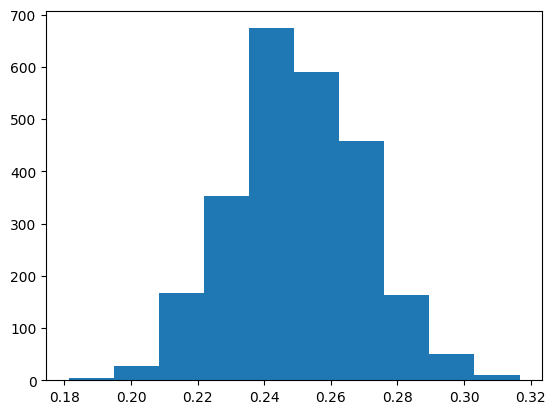

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.31666666666666665
Balanced Accuracy:  0.31666666666666665
Micro F1-Score:  0.31666666666666665
Macro F1-Score:  0.3136804933466333
{'original': False, 'pca': True, 'ica': False, 'dwt': False, 'onevall_csp': False, 'pairwise_csp': False}
---Working on principle Component Analysis---
(1756, 1756) (480, 1756)


100%|██████████| 2500/2500 [10:37<00:00,  3.92it/s]


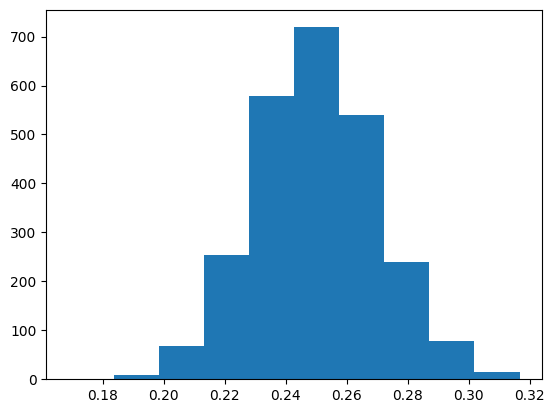

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.31666666666666665
Balanced Accuracy:  0.31666666666666665
Micro F1-Score:  0.31666666666666665
Macro F1-Score:  0.3158281961349397
{'original': False, 'pca': False, 'ica': True, 'dwt': False, 'onevall_csp': False, 'pairwise_csp': False}
---Working on Independent Component Analysis---
(1756, 1756) (480, 1756)


100%|██████████| 2500/2500 [10:52<00:00,  3.83it/s]


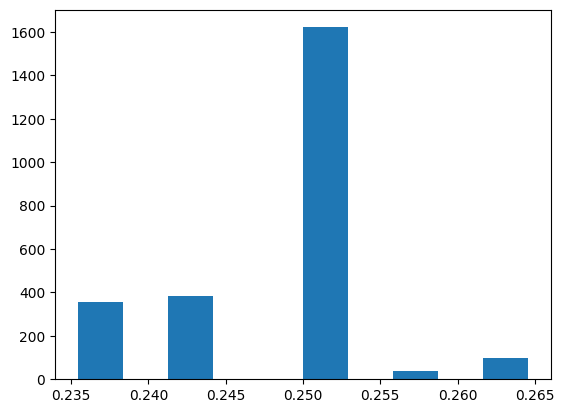

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.26458333333333334
Balanced Accuracy:  0.26458333333333334
Micro F1-Score:  0.26458333333333334
Macro F1-Score:  0.1763436368699527
{'original': False, 'pca': False, 'ica': True, 'dwt': False, 'onevall_csp': False, 'pairwise_csp': False}
---Working on Independent Component Analysis---
(1756, 1756) (480, 1756)


100%|██████████| 2500/2500 [10:58<00:00,  3.80it/s]


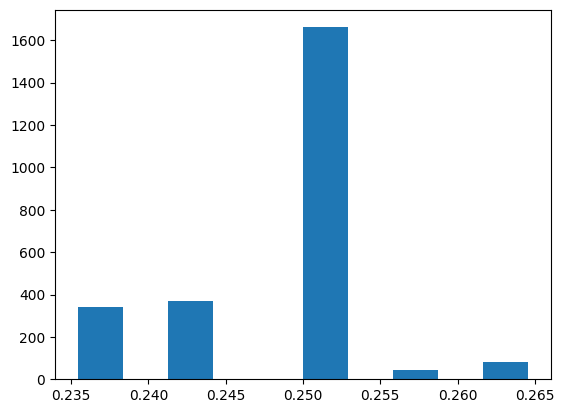

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.26458333333333334
Balanced Accuracy:  0.26458333333333334
Micro F1-Score:  0.26458333333333334
Macro F1-Score:  0.1763436368699527
{'original': False, 'pca': False, 'ica': False, 'dwt': True, 'onevall_csp': False, 'pairwise_csp': False}
---Working on Discrete Wavelet Transform---
(1756, 33152) (480, 33152)


100%|██████████| 2500/2500 [3:34:55<00:00,  5.16s/it]


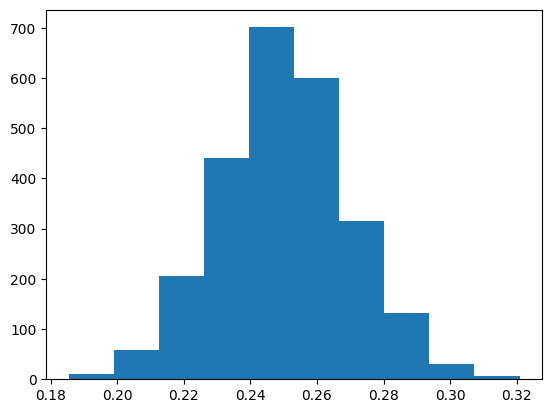

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.32083333333333336
Balanced Accuracy:  0.3208333333333333
Micro F1-Score:  0.32083333333333336
Macro F1-Score:  0.32015650116802247
{'original': False, 'pca': False, 'ica': False, 'dwt': True, 'onevall_csp': False, 'pairwise_csp': False}
---Working on Discrete Wavelet Transform---
(1756, 33152) (480, 33152)


100%|██████████| 2500/2500 [3:30:48<00:00,  5.06s/it]


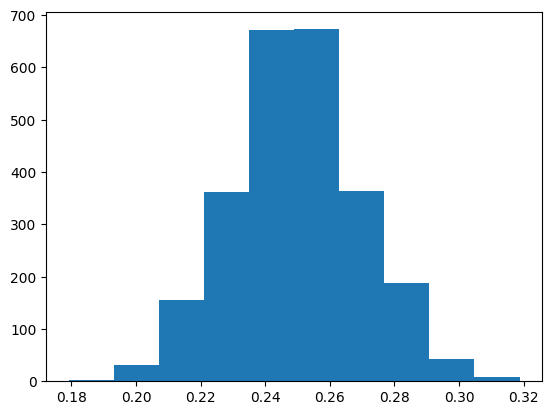

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.31875
Balanced Accuracy:  0.31875
Micro F1-Score:  0.31875
Macro F1-Score:  0.3188901020964643
{'original': False, 'pca': False, 'ica': False, 'dwt': False, 'onevall_csp': True, 'pairwise_csp': False}
---Working on Common Spatial Pattern One Vs All---
(1756, 512) (480, 512)


100%|██████████| 2500/2500 [04:01<00:00, 10.34it/s]


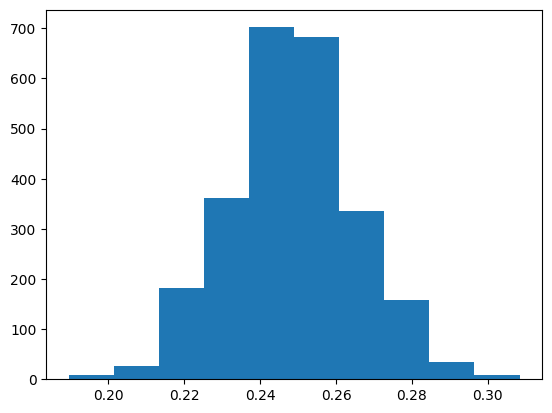

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.30833333333333335
Balanced Accuracy:  0.30833333333333335
Micro F1-Score:  0.30833333333333335
Macro F1-Score:  0.30026724140421635
{'original': False, 'pca': False, 'ica': False, 'dwt': False, 'onevall_csp': True, 'pairwise_csp': False}
---Working on Common Spatial Pattern One Vs All---
(1756, 512) (480, 512)


100%|██████████| 2500/2500 [03:49<00:00, 10.88it/s]


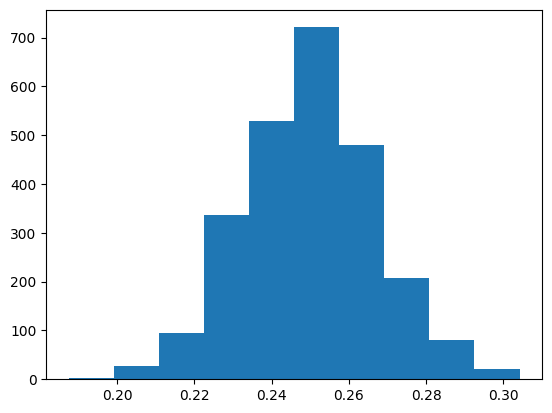

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.30416666666666664
Balanced Accuracy:  0.30416666666666664
Micro F1-Score:  0.30416666666666664
Macro F1-Score:  0.297984967691069
{'original': False, 'pca': False, 'ica': False, 'dwt': False, 'onevall_csp': False, 'pairwise_csp': True}
---Working on Common Spatial Pattern Pairwise---
(1756, 768) (480, 768)


100%|██████████| 2500/2500 [05:03<00:00,  8.23it/s]


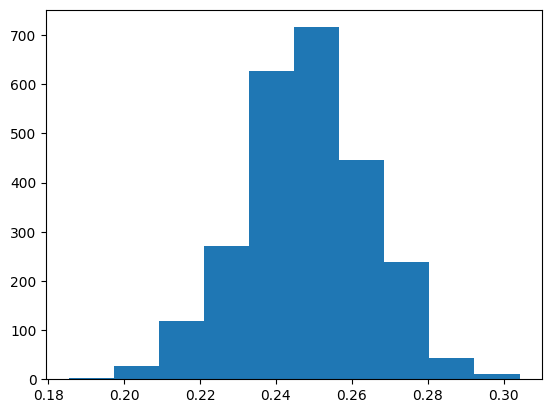

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.30416666666666664
Balanced Accuracy:  0.3041666666666667
Micro F1-Score:  0.30416666666666664
Macro F1-Score:  0.2909149401297776
{'original': False, 'pca': False, 'ica': False, 'dwt': False, 'onevall_csp': False, 'pairwise_csp': True}
---Working on Common Spatial Pattern Pairwise---
(1756, 768) (480, 768)


100%|██████████| 2500/2500 [04:53<00:00,  8.53it/s]


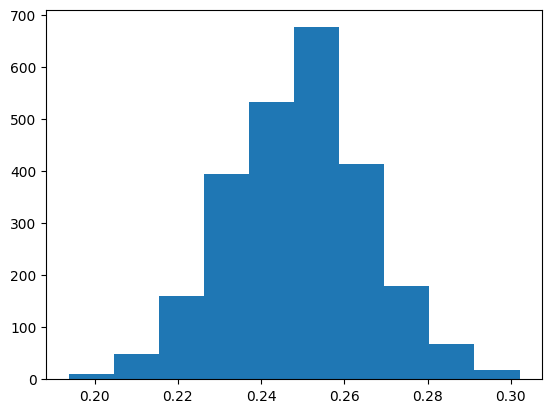

--------------------------------------------------
Training Scores:

Accuracy:  1.0
Balanced Accuracy:  1.0
Micro F1-Score:  1.0
Macro F1-Score:  1.0


Testing Scores:

Accuracy:  0.3020833333333333
Balanced Accuracy:  0.30208333333333337
Micro F1-Score:  0.3020833333333333
Macro F1-Score:  0.29564908450279254


In [11]:
from sklearn.model_selection import GroupShuffleSplit
from lazypredict.Supervised import LazyClassifier

# Conditions to compared
Conditions = [["Inner"],["Inner"],["Inner"],["Inner"]]
# The class for the above condition
Classes    = [  ["Up"] ,["Down"], ["Left"] ,["Right"] ]

#@title Data extraction and processing

X_all = []
Y_all = []
groups_all = []

for i in range(1,11):
    # Load all trials for a sigle subject
    X, Y = extract_data_from_subject(root_dir, i, datatype)

    # Cut usefull time. i.e action interval
    X = select_time_window(X = X, t_start = t_start, t_end = t_end, fs = fs)

    # Transform data and keep only the trials of interes
    X , Y =  transform_for_classificator(X, Y, Classes, Conditions)
    
    X_all.append(X)
    Y_all.append(Y)
    print(len(Y))
    groups_all.extend([i]*len(Y))
    
# Merge the numpy arrays across the first axis
X = np.concatenate(X_all, axis=0)
Y = np.concatenate(Y_all, axis=0)

groups = np.array(groups_all)


preprocessing_tester(X, Y, "all_subj")